# This notebook uses all the script to train a CAE for DNase

In [130]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import json
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
testing = False
    
# The base directory is one level up
base = '..'
settings_filepath = (
    '../settings-grch38-dnase-12kb-testing.json'
    if testing
    else '../settings-grch38-dnase-12kb.json'
)
cnn_search_filepath = '../cnn-search.json'
optimizer_search_filepath = '../optimizer-search.json'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load settings

In [6]:
with open(settings_filepath, "r") as f:
    settings = json.load(f)

with open(cnn_search_filepath, "r") as f:
    cnn_search = json.load(f)

with open(optimizer_search_filepath, "r") as f:
    optimizer_search = json.load(f)

### 1. Find DNase datasets on ENCODE

In [10]:
from find import find

datasets_filepath = find(settings, base=base, clear=True, verbose=True, strict=True)

Search for experiments... done!
Found 57 human DNase-seq experiments
Download metadata... done!
Removed 40 experiments due to auditing errors
Found 12 experiments comprising 12 datasets
Saved dataset accessions to ../datasets-grch38-dnase-2019-02-15-strict.json


In [11]:
# Comment out or remove the following line. It's only used for testing
# testing = True
datasets_filepath = '../datasets-grch38-dnase-testing.json' if testing else datasets_filepath
with open(datasets_filepath, "r") as f:
    datasets = json.load(f)
    dataset_ids = list(datasets.keys())

### 2. Download the datasets

In [80]:
from download import download

download(datasets, settings, base=base, clear=False, verbose=True)

The data will be downloaded to `../data`.

### 3. Create jobs for preparing all the datasets

In [2]:
from prepare import prepare_jobs

datasets_filepath = '../datasets-grch38-dnase-testing.json'

prepare_jobs(
    'DNase',
    os.path.relpath(datasets_filepath, base),
    os.path.relpath(settings_filepath, base),
    base=base,
    clear=False,
    verbose=False,
)

Failed to import duecredit due to No module named 'duecredit'


Created a slurm file for preparing 4 datasets


In [27]:
"""Check if all datasets have been prepared"""

import h5py

try:
    with open(os.path.join(base, "datasets-grch38-dnase-2019-02-16.json"), "r") as f:
        all_datasets = json.load(f).keys()
except FileNotFoundError:
    all_datasets = []
    print("Damn! Where is the file with the ENCODE experiments?")

not_found = []
outdated = []
total_size = 0

for dataset in all_datasets:
    filepath = os.path.join(base, 'data', '{}.h5'.format(dataset))
    total_size += os.path.getsize(filepath)
    try:
        with h5py.File(filepath, "r") as f:
            try:
                x = f['data_train']
                x = f['data_dev']
                x = f['data_test']
                x = f['peaks_train']
                x = f['peaks_dev']
                x = f['peaks_test']
                x = f['shuffling']
                x = f['settings']
            except KeyError:
                outdated.append(dataset)
    except OSError:
        not_found.append(dataset)

print("{} are not found".format(len(not_found)))
print("{} are not outdated".format(len(outdated)))

0 are not found
0 are not outdated


In [29]:
import math

def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

convert_size(total_size)

'37.06 GB'

Start preparation with `sbatch prepare.slurm`.

### 3.5 Test data preparation

In [5]:
from prepare import prepare

settings['incl_pctl_total_signal'] = 50
settings['incl_pct_no_signal'] = 5
settings['peak_ratio'] = 2

prepare(
    'DNase',
    datasets,
    settings,
    single_dataset='ENCSR320PGJ',
    base=base,
    clear=True,
    verbose=True,
)

Window size: 12000bp
Resolution: 100bp
Bins per window: 120
Step frequency per window: 2
Step size: 6000bp
Chromosomes: chr1, chr2, chr3, chr4, chr5, chr6, chr7, chr8, chr9, chr10, chr11, chr12, chr13, chr14, chr15, chr16, chr17, chr18, chr19, chr20, chr21, chr22, chrX
Dev set size: 7.5%
Test set size: 7.5%
Percentile cut off: [0, 99.9]

Prepare dataset ENCSR320PGJ
Remove incomplete data to avoid inconsistencies
Extract windows from ENCFF915OOI.bigWig.......................
Extract narrow peaks from ENCFF734JDX.bigBed.......................
Extract broad peaks from ENCFF179DPX.bigBed.......................
Select windows to balance peaky and non-peaky ratio
Windows: total = 505160 | with peaks = 119866 | with signal gt 50 pctl = 73917
Train: 164715 (with 61.74% peaks) Dev: 14534 (with 62.61% peaks) Test: 14534 (with 62.41% peaks)
Saving... done!


Train data shape: (5698, 120, 1)
Train peaks shape: (5698,) num windows with peaks 2872 (50.40%)
Dev data shape: (503, 120, 1)
Dev peaks shape: (503,) num windows with peaks 238 (47.32%)
Test data shape: (503, 120, 1)
Test peaks shape: (503,) num windows with peaks 242 (48.11%)
88 (1.54%) out of 5698 windows are empty


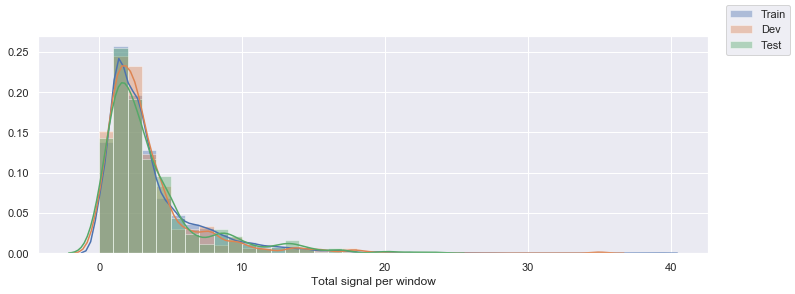

In [96]:
"""Sanity check that the normalization really worked"""

from ae.utils import plot_total_signal

plot_total_signal('ENCSR320PGJ', base=base)

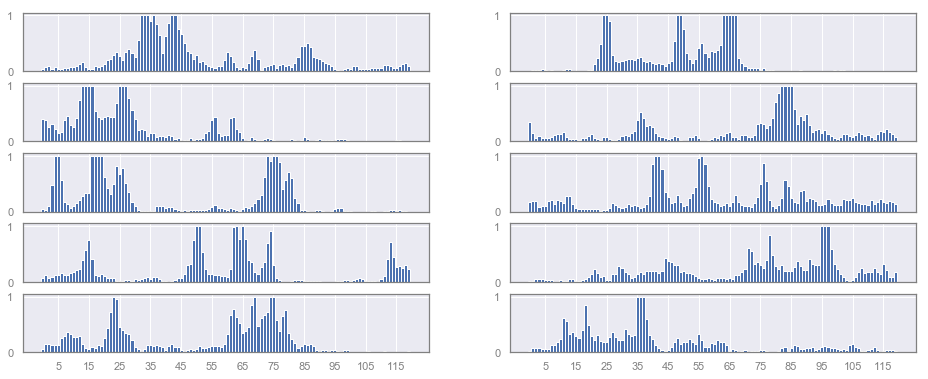

In [133]:
from ae.utils import plot_windows

plot_windows('ENCSR320PGJ', min_signal=20, base=base)

In [30]:
"""Merge data"""

from merge import merge

with open('../datasets-grch38-dnase-testing.json', "r") as f:
    datasets = json.load(f)

merge(
    datasets,
    settings,
    name='merged2',
    base=base,
    clear=True,
    verbose=False,
    dtype='float32'
)

In [31]:
"""Compare file sizes"""

import h5py

try:
    with open(os.path.join(base, "datasets-grch38-dnase-testing.json"), "r") as f:
        all_datasets = json.load(f).keys()
except FileNotFoundError:
    all_datasets = []
    print("Damn! Where is the file with the ENCODE experiments?")

not_found = []
outdated = []
total_size = 0

for dataset in all_datasets:
    filepath = os.path.join(base, 'data', '{}.h5'.format(dataset))
    total_size += os.path.getsize(filepath)

merged_size = os.path.getsize(os.path.join(base, 'data', 'merged2.h5'))
    
import math

def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

print(
    convert_size(total_size),
    convert_size(merged_size)
)

22.7 MB 11.23 MB


### 4. Create jobs for training various CAE models

In [5]:
from jobs import jobs

jobs(
    optimizer_search,
    os.path.relpath(settings_filepath, base),
#     datasets=os.path.relpath(datasets_filepath, base),
    dataset='merged',
    epochs=10,
#     batch_size=1024,
    peak_weight=1,
    base=base,
    clear=True,
    verbose=False
)


Created slurm file for training 72 neural networks


### 5. Test CAEs training

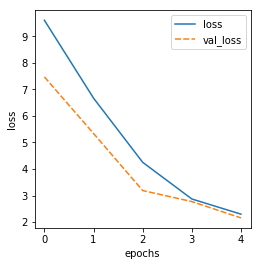

In [80]:
from train import train_on_single_dataset

model_name = 'cf-32-64-128--ck-3-5-7--du-1024-256--do-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0'

with open('../models/{}.json'.format(model_name), 'r') as f:
    definition = json.load(f)

train_on_single_dataset(
    settings,
    'merged',
    definition=definition,
    epochs=5,
    batch_size=64,
    base=base,
    clear=True,
)

In [137]:
'{}---autoencoder-{}'.format(model_name, 'merged')

'cf-32-64-128--ck-3-5-7--du-1024-256--do-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0---autoencoder-merged'

In [139]:
from compare import compare
    
losses = compare(
    'definitions-cnn-search.json',
    dataset_name='cnn-search',
    base=base,
    clear=False,
    verbose=False,
    silent=False,
    remove_common_prefix_from_df=True,
)

../models/cf-32-64-128--ck-3-5-7--du-1024-256--do-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0---autoencoder-merged.h5


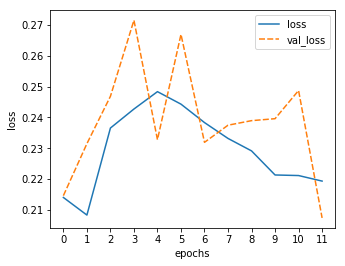

In [11]:
"""Test retraining"""

train_on_single_dataset(
    settings,
    'merged',
    pre_trained_model_name='{}---autoencoder-{}'.format(model_name, 'merged'),
    definition=definition,
    epochs=12,
    batch_size=512,
    base=base,
    checkpoint=True,
    clear=True,
)

In [ ]:
from train import train_on_single_dataset

with open('../definitions.json', 'r') as d:
    definitions = json.load(d)
    
for model_name in definitions:
    print('Train: {}'.format(model_name))
    # Load the CAE definition, training settings, datasets, and define training parameters
    with open('../models/{}.json'.format(model_name), 'r') as f:
        definition = json.load(f)

    # Start the training
    train_on_single_dataset(
        settings,
        'merged',
        definition,
        epochs=5,
        batch_size=128,
        peak_weight=2,
        signal_weighting='logn',
        signal_weighting_zero_point_percentage=0.02,
        base=base,
        clear=True,
        train_on_hdf5=False,
        train_on_cnn2=False,
    )

In [ ]:
import warnings

from evaluate import evaluate

with open('../definitions.json', 'r') as d:
    definitions = json.load(d)
    
for model_name in definitions:
    print('Evaluate: {}'.format(model_name))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        evaluate(
            model_name,
            dataset_name='merged',
            base=base,
            clear=True
        )

#### Visualize training and validation loss

(array([17148,  2826, 12961, 16409, 19182,  3801,  6608, 11261, 20285,
         8136,  5289, 19304,   330, 14065, 14303, 13490, 16474,  6471,
         9208,  1615]),
 array([17.78854793,  5.82939038,  8.69929147,  7.31179766, 10.86529094,
         5.36262544,  5.61451418,  6.32741934,  8.47223406,  8.7461852 ,
         6.87221153,  7.91825307,  9.53525347, 10.46925961,  5.69641812,
         7.84405512,  5.9444642 , 22.19208933, 16.00051382,  5.75986464]),
 array([0.91828461, 0.30917173, 0.70750291, 0.59409283, 0.6036661 ,
        0.31524655, 0.14616569, 0.46696346, 0.88293796, 0.59613081,
        0.55685823, 0.94093344, 0.94904709, 0.22916685, 0.83310475,
        0.74523971, 0.70521172, 1.        , 1.        , 0.53994118]))

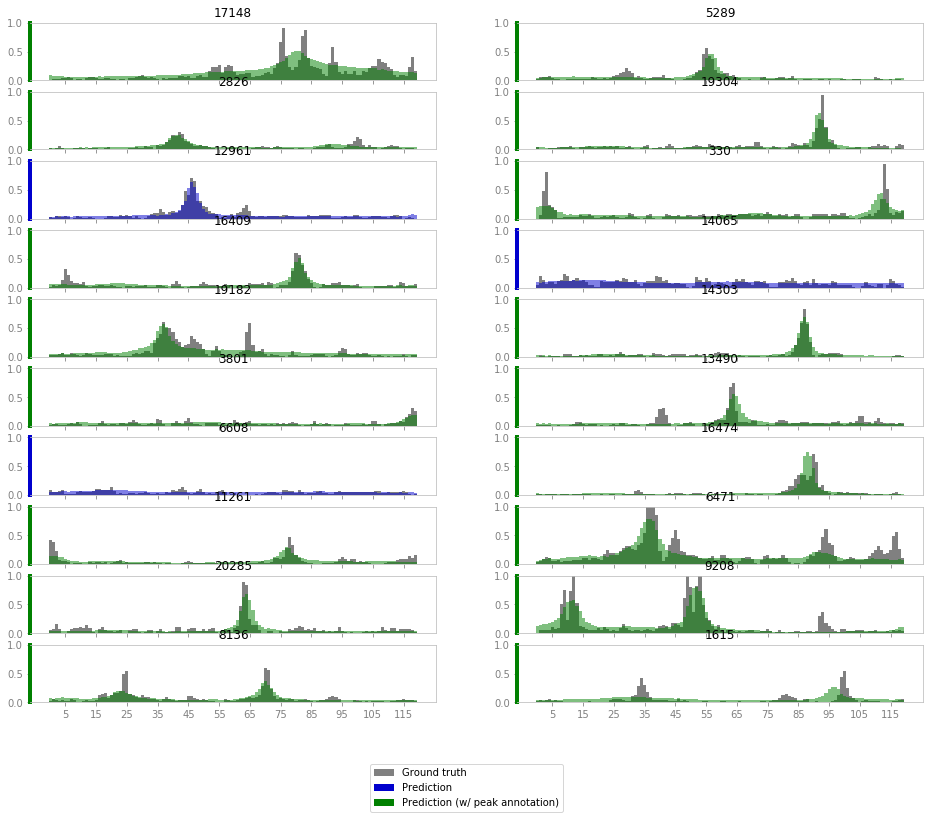

In [131]:
from ae.utils import plot_windows

num_windows = 20
plot_windows(
    'merged',
    model_name=model_name,
    trained_on_single_dataset=True,
    ds_type='train',
    num=num_windows,
    min_signal=5,
    base=base
)

(array([ 3847, 12772,  6793, 13159,  9070, 16500, 13205,  7413, 11429,
        17928,  1501,  1664,  1678,  1095, 13636, 10140,  4878,  5220,
        10694, 18818]),
 array([10.81052635,  5.23350484,  6.48512629,  7.57342136,  5.32298098,
         6.835544  ,  5.74309838,  5.37793077,  8.27122762,  9.39279746,
         6.11310238,  5.01544015,  6.12308079,  6.99207156,  6.90179397,
         7.9437227 ,  5.04580614,  7.01684621,  6.95635772,  6.72222731]),
 array([0.99107213, 0.17994465, 0.46726245, 0.49603211, 0.7509868 ,
        0.90858045, 0.67307662, 0.34218553, 0.80596909, 1.        ,
        0.31150805, 0.28461133, 0.92185954, 0.47916736, 0.46627041,
        0.89390343, 0.10705097, 0.25944813, 0.16170666, 0.90773836]))

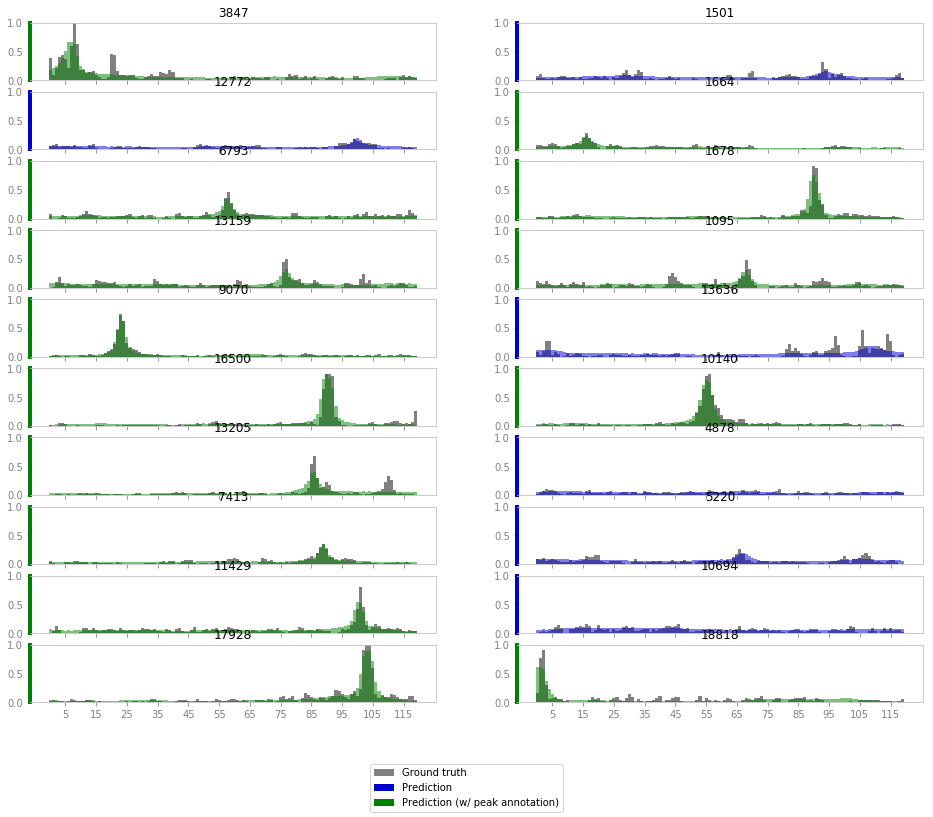

In [126]:
from ae.utils import plot_windows

num_windows = 20
plot_windows(
    'merged',
    model_name=model_name,
    custom_postfix='re-trained',
    trained_on_single_dataset=True,
    ds_type='train',
    num=num_windows,
    min_signal=5,
    base=base
)

### 6. Evaluate CAEs

In [31]:
from evaluate import evaluate

evaluate(
    'cf-32-64-128--ck-3-5-7--du-512-256-128--do-0-0-0-0-0-0--e-10--rl-0--o-adam--lr-0.01--lrd-0.0--l-smse-2--m-',
    datasets,
    base=base,
    clear=True
)

In [41]:
from ae.cnn import create_model

definition_name = 'cf-128--ck-11--du-512-128--do-0-0-0--e-10--rl-0--o-adam--lr-0.01--lrd-0.0--l-bce--m-'
definition_name = 'cf-512-128-32--ck-11-11-11--du-512-128--do-0-0-0-0-0--e-10--rl-0--o-adam--lr-0.01--lrd-0.0--l-bce--m-'
definition_filepath = os.path.join(base, 'models', '{}.json'.format(definition_name))

definition = None

try:
    with open(definition_filepath, "r") as f:
        definition = json.load(f)
except FileNotFoundError:
    sys.stderr.write("Please provide a definition file")


if definition is not None:
    encoder, decoder, autoencoder = create_model(120, **definition)
    autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoded_input (InputLayer)   (None, 120, 1)            0         
_________________________________________________________________
conv0 (Conv1D)               (None, 60, 512)           6144      
_________________________________________________________________
drop0 (Dropout)              (None, 60, 512)           0         
_________________________________________________________________
conv1 (Conv1D)               (None, 30, 128)           721024    
_________________________________________________________________
drop1 (Dropout)              (None, 30, 128)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 15, 32)            45088     
_________________________________________________________________
drop2 (Dropout)              (None, 15, 32)            0         
__________

(array([1758,  178, 1437,  361,  904,  808, 1375,  547, 1272,   62,  976,
         995, 1213, 1087,  382,  891,  145, 1182, 1477, 1457]),
 array([ 5.61142453,  3.03751203,  9.17108895,  4.05918661, 11.19665497,
         4.71893602,  4.67266929,  5.83497159,  9.11012916,  3.10859515,
         3.64738553,  7.05507012, 18.16587718,  5.13947533,  3.00595572,
         6.67361888,  5.49161984,  4.38661419,  3.84480811,  5.00051415]),
 array([0.89346349, 0.19402105, 0.92237041, 0.37313388, 1.        ,
        0.1982249 , 0.43695252, 0.56487946, 0.35218282, 0.0936695 ,
        0.15937921, 0.21770461, 1.        , 0.11168301, 0.16369055,
        0.58631012, 0.4428014 , 0.20735422, 0.44123258, 0.16314962]))

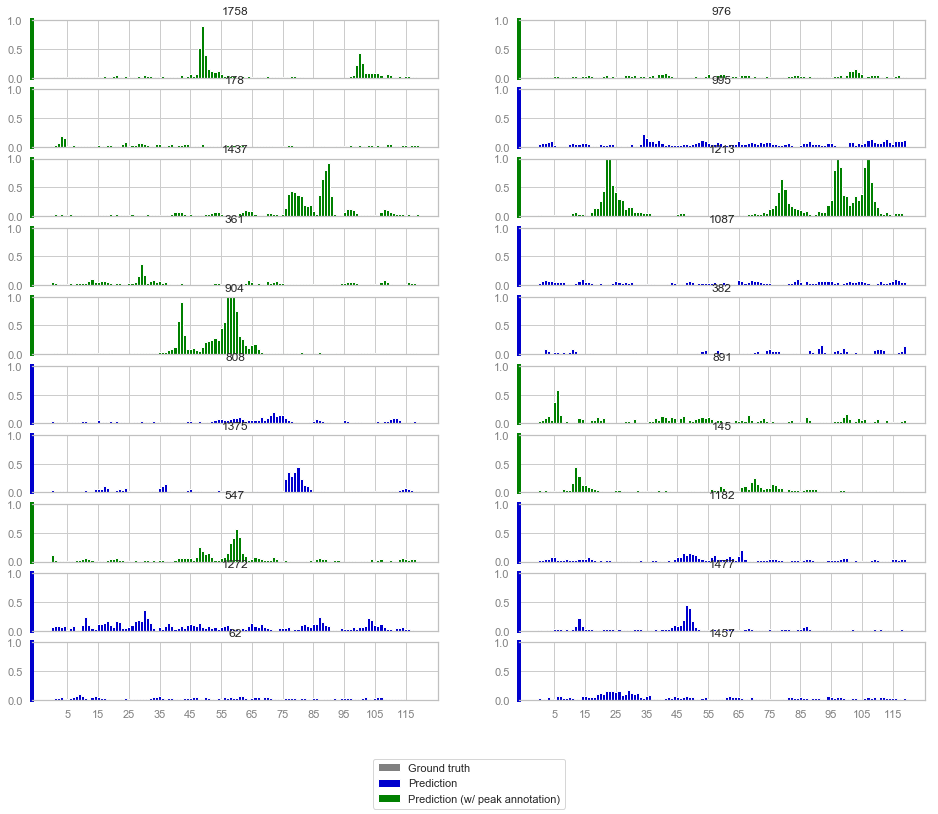

In [72]:
from ae.utils import plot_windows

plot_windows('merged', ds_type='test', num=20, min_signal=3, base=base)

/Users/Fritz/miniconda3/envs/px/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/Fritz/miniconda3/envs/px/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Predict 1826 windows... done!
Compute #0 metric (keras) ... done!
Compute #1 metric (keras) ... done!
Compute #2 metric (keras) ... done!
Compute #3 metric (keras) ... done!
Compute #4 metric (keras) ... done!
Compute #5 metric (keras) ... done!
Compute #6 metric (keras) ... done!
Compute #7 metric (keras) ... done!
Compute #8 metric (keras) ... done!
Compute #9 metric (keras) ... done!


/Users/Fritz/miniconda3/envs/px/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/Fritz/miniconda3/envs/px/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


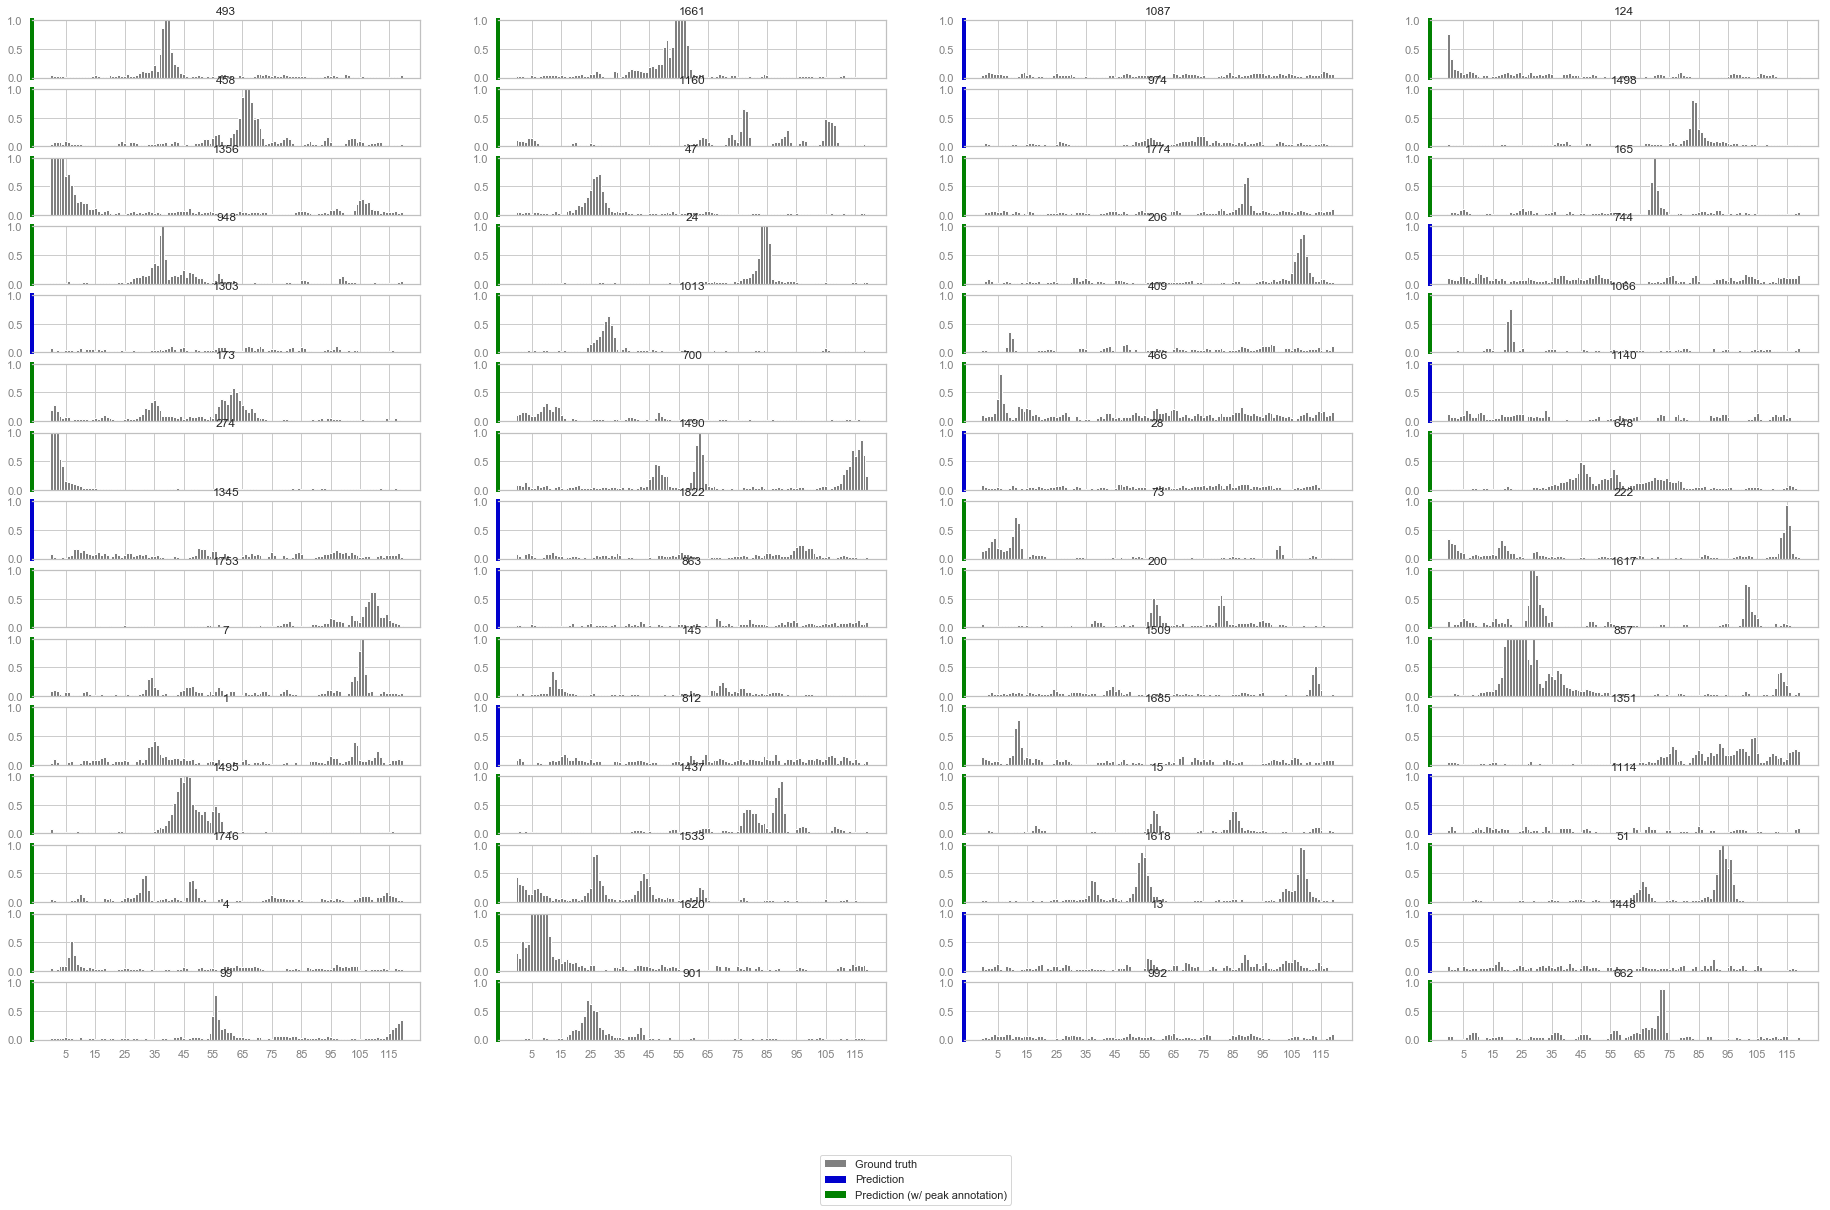

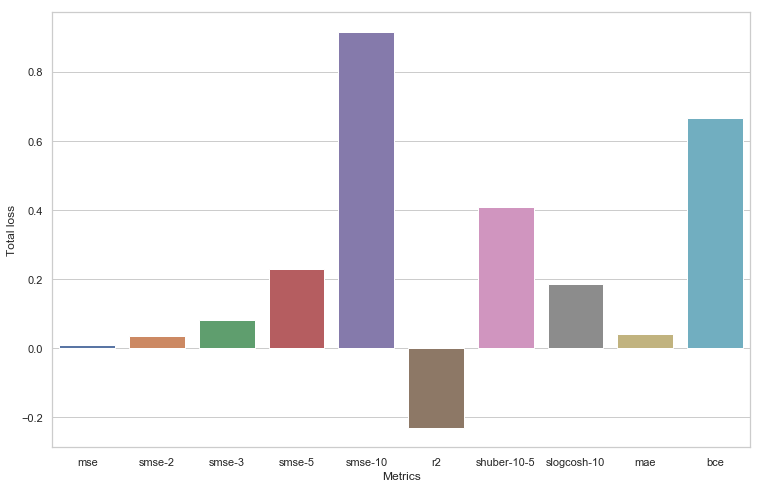

In [180]:
import qgrid

loss = evaluate(
    'cf-32-64-128--ck-3-5-7--du-512-256-128--do-0-0-0-0-0-0--e-10--rl-0--o-adam--lr-0.01--lrd-0.0--l-smse-2--m-',
    dataset_name='merged',
    base=base,
    verbose=True,
    clear=True
)

In [106]:
import h5py
from keras.metrics import mse, mae, binary_crossentropy
from keras.models import load_model

from ae.utils import predict, evaluate_model

model_name = 'cf-32-64-128--ck-3-5-7--du-512-256-128--do-0-0-0-0-0-0--e-10--rl-0--o-adam--lr-0.01--lrd-0.0--l-smse-2--m-'
dataset_name = 'merged'

encoder_filepath = os.path.join(
    base, "models", "{}---encoder-{}.h5".format(model_name, dataset_name)
)
decoder_filepath = os.path.join(
    base, "models", "{}---decoder-{}.h5".format(model_name, dataset_name)
)

encoder = load_model(encoder_filepath)
decoder = load_model(decoder_filepath)

data_filepath = '../data/{}.h5'.format(dataset_name)

with h5py.File(data_filepath, "r") as f:
    data_test = f["data_test"][:]
    
    losses, prediction = evaluate_model(encoder, decoder, data_test, keras_metrics=[mse,mae,binary_crossentropy])

/Users/Fritz/miniconda3/envs/px/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/Users/Fritz/miniconda3/envs/px/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [12]:
from evaluate import create_jobs

create_jobs(
    'cnn-search',
    dataset='merged',
    cluster="cox",
    base=base,
    incl_dtw=False,
)

Created slurm file for evaluating 194 neural networks
